# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# План:

- Загрузите и подготовьте данные. Поясните порядок действий.
- Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
- Улучшите качество модели, учитывая дисбаланс классов. 
- Обучите разные модели и найдите лучшую. Кратко опишите выводы.
- Проведите финальное тестирование.

# 1. Подготовка данных

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [48]:
df=pd.read_csv('Churn.csv')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В данном датасете 13 признако, целевой признак, 10000 строк.
### Признаки:
- wNumber — индекс строки в данных (int64)
- CustomerId — уникальный идентификатор клиента (int64)
- Surname — фамилия (object)
- CreditScore — кредитный рейтинг (int64)
- Geography — страна проживания (object)
- Gender — пол (object)
- Age — возраст (int64)
- Tenure — количество недвижимости у клиента (float64)
- Balance — баланс на счёте (float64)
- NumOfProducts — количество продуктов банка, используемых клиентом (int64)
- HasCrCard — наличие кредитной карты (int64)
- IsActiveMember — активность клиента (int64)
- EstimatedSalary — предполагаемая зарплата (float64)
### Целевой признак:
- Exited — факт ухода клиента (int64)



## Вывод:

В данных присутствуют столбцы, которые не нужны. Их можно удалить. В анализе они не нужны. Также есть пропуски в значении недвижимости. Это означает, что у клиента нет ее. Значит можно просто заменить 0 и перевести в целочисленный тип.  

In [50]:
# Удаляю лишние столбцы
del_col=['RowNumber','EstimatedSalary','CustomerId','Surname']
df=df.drop(del_col,axis=1)

In [51]:
# Заполняю пропуски 0
df['Tenure']=df['Tenure'].fillna(0).astype('int64')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
CreditScore       10000 non-null int64
Geography         10000 non-null object
Gender            10000 non-null object
Age               10000 non-null int64
Tenure            10000 non-null int64
Balance           10000 non-null float64
NumOfProducts     10000 non-null int64
HasCrCard         10000 non-null int64
IsActiveMember    10000 non-null int64
Exited            10000 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 781.4+ KB


In [53]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,619,France,Female,42,2,0.00,1,1,1,1
1,608,Spain,Female,41,1,83807.86,1,0,1,0
2,502,France,Female,42,8,159660.80,3,1,0,1
3,699,France,Female,39,1,0.00,2,0,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,0


# 2. Исследование задачи

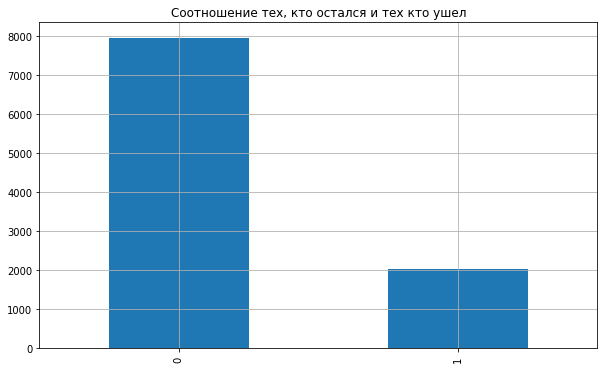

In [54]:
# Рисую гистограмму значений оттока и оставшихся клиентов
df['Exited'].value_counts().plot(kind='bar',grid=True,figsize=(10,6),title='Соотношение тех, кто остался и тех кто ушел')

Соотношение оттока и тех кто остался 1:4.
Вывод: такое соотношение говорит, что присутствует дисбаланс в данных. 

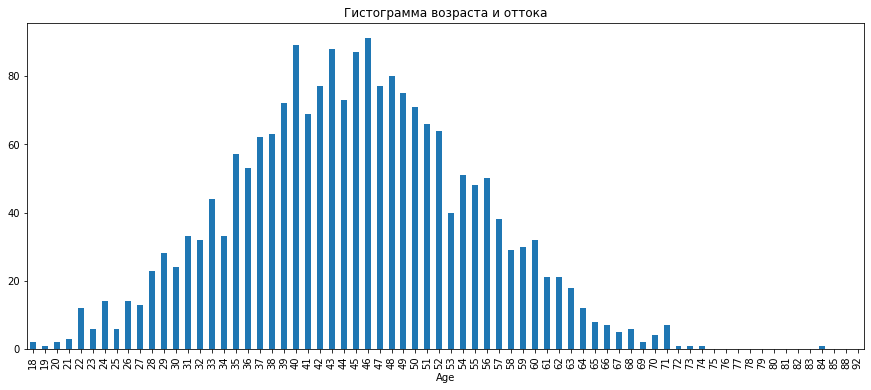

In [55]:
# Посмотрим как зависит возраст и отток клиентов 
df.groupby('Age')['Exited'].sum().plot(figsize=(15,6),kind='bar',title='Гистограмма возраста и оттока')
plt.show()

По гистограмме распределения видно, что отток зависит от возраста и распределено нормально. Больше всего уходит клиентов в возрасте от 40 до 50 лет.

---

### Комментарий наставника

Для того, чтобы делать какие-либо выводы о зависимости признака и целевой переменной по графику распределения, необходимо построить распределение признака у альтернативного значения целевого значения.

Не исключено, что в целом форма распределения будет похожей, и тогда нельзя однозначно утверждать, что возраст имеет прямое влияние на целевую переменную.

Более того, для закрепления сформированной гипотезы, следует провести статистический тест на равенство средних двух выборок (значения признака, разделенные по целевому значению 0 и 1).

И после этих оценок, уже можно давать какие-либо утверждения. Они будут иметь больший вес.

ЭТО ВАЖНЫЙ МОМЕНТ

---

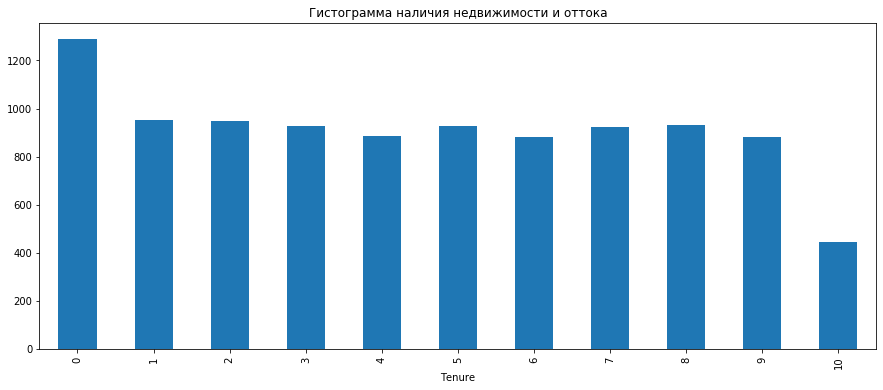

In [56]:
# Посмотрим как зависит наличие недвижимости и отток клиентов 
df.groupby('Tenure')['Exited'].count().plot(figsize=(15,6),kind='bar',title='Гистограмма наличия недвижимости и оттока')
plt.show()

На этой гисторгамме видна не очень сильная зависимость, но можно увидеть, что те у кого нет недвижимости уходят чаще.

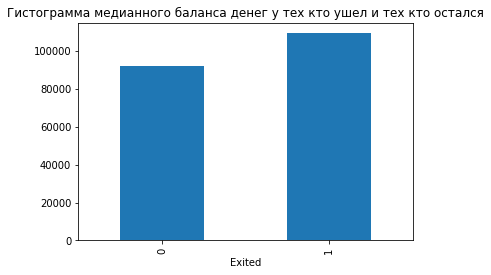

In [57]:
df.groupby('Exited')['Balance'].median().plot(kind='bar',title='Гистограмма медианного баланса денег у тех кто ушел и тех кто остался')


На гистограмме видно, что зависимость не сильная, но среднее значение баланса немного выше у тех кто ушел.

In [58]:
df.corr() # Считаю корреляцию Пирсона

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
CreditScore,1.000000,-0.003965,0.003087,0.006268,0.012238,-0.005458,0.025651,-0.027094
Age,-0.003965,1.000000,-0.007368,0.028308,-0.030680,-0.011721,0.085472,0.285323
Tenure,0.003087,-0.007368,1.000000,-0.005821,0.010106,0.021387,-0.025856,-0.013319
Balance,0.006268,0.028308,-0.005821,1.000000,-0.304180,-0.014858,-0.010084,0.118533
NumOfProducts,0.012238,-0.030680,0.010106,-0.304180,1.000000,0.003183,0.009612,-0.047820
HasCrCard,-0.005458,-0.011721,0.021387,-0.014858,0.003183,1.000000,-0.011866,-0.007138
IsActiveMember,0.025651,0.085472,-0.025856,-0.010084,0.009612,-0.011866,1.000000,-0.156128
Exited,-0.027094,0.285323,-0.013319,0.118533,-0.047820,-0.007138,-0.156128,1.000000


Видно, что все признаки не сильно коррелируются с целевым признаком. Скорее всего там зависимость сложнее.

## One hot encoder
Избавляемся от категориальных признаков методом One hot encoder

In [59]:
df_ohe=pd.get_dummies(df,drop_first=True) # вызываем метод get_dummies для избавления от категориальных признаков

In [60]:
target=df_ohe['Exited'] # Целевой признак
features=df_ohe.drop(['Exited'],axis=1) # Признаки

In [61]:
train_features,valid_features,train_target,valid_target=train_test_split(features,target,test_size=0.25,random_state=1234)
#Разбиваем данные после OHE на четыре выборки train_features,valid_features,train_target,valid_target

In [62]:
# Стандартизируем тестовую и валидную выборку, т.к есть значения и маленькие и очень большие. 
numeric=['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember']
scaler=StandardScaler()
scaler.fit(train_features[numeric])
train_features[numeric]=scaler.transform(train_features[numeric])
valid_features[numeric]=scaler.transform(valid_features[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

---

### Комментарий наставника

Согласен с тобой. Например, логистическая регрессия может "не простить" сильные различия в масштабах, если не привести +- одинаковой шкале.

---

## Original Encoder

In [18]:
## Original Encoder

In [19]:
#encoder=OrdinalEncoder()
#original_df=pd.DataFrame(encoder.fit_transform(df),columns=df.columns)

In [20]:
#original_df.head()

In [21]:
#target=original_df['Exited']
#features=original_df.drop(['Exited'],axis=1)

Метод Original encoder не принес хорошего результат, поэтому я его закомментировал

# Строю модель без учета баланса

## Обучение с помощью модели Дерево решения

In [63]:
# Циклом ищем лучший гиперпораметр max_depth

for depth in range(1,10,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=1234).fit(train_features,train_target)
    prediction=model_tree.predict(valid_features)
    print('max_depth:',depth,'F1:',f1_score(valid_target,prediction))

max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.5207373271889401
max_depth: 3 F1: 0.4029850746268657
max_depth: 4 F1: 0.4648648648648649
max_depth: 5 F1: 0.5144356955380577
max_depth: 6 F1: 0.5209424083769634
max_depth: 7 F1: 0.5860889395667048
max_depth: 8 F1: 0.5550239234449761
max_depth: 9 F1: 0.5444191343963554


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Вывод: лучшее значение max_depth=7, при котором F1=0,586

## Обучение с помощью модели Случайный лес

In [64]:
# Циклом ищем лучший гиперпораметр max_depth

for max_depth in range(1,20,1):
    model_forest=RandomForestClassifier(max_depth=max_depth,n_estimators=50,random_state=1234).fit(train_features,train_target)
    prediction=model_forest.predict(valid_features)
    print('max_depth:',max_depth,'F1:',f1_score(valid_target,prediction))
    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.18214285714285713
max_depth: 3 F1: 0.3056910569105691
max_depth: 4 F1: 0.39696969696969703
max_depth: 5 F1: 0.4868603042876901
max_depth: 6 F1: 0.5013698630136987
max_depth: 7 F1: 0.5336856010568032
max_depth: 8 F1: 0.5397653194263363
max_depth: 9 F1: 0.5586734693877552
max_depth: 10 F1: 0.5641025641025641
max_depth: 11 F1: 0.571072319201995
max_depth: 12 F1: 0.5671641791044776
max_depth: 13 F1: 0.561186650185414
max_depth: 14 F1: 0.5668711656441718
max_depth: 15 F1: 0.5585365853658536
max_depth: 16 F1: 0.5543345543345544
max_depth: 17 F1: 0.5543345543345544
max_depth: 18 F1: 0.5578562728380024
max_depth: 19 F1: 0.5590361445783133


### Вывод: лучшее значение max_depth=11, при котором F1=0,571

In [65]:
# Циклом подбираем гиперпораметр n_estimators (количество деревьев)
for estim in range(1,50,2):
    model_forest=RandomForestClassifier(max_depth=11,n_estimators=estim,random_state=1234).fit(train_features,train_target)
    prediction=model_forest.predict(valid_features)
    print('estim',estim,'F1:',f1_score(valid_target,prediction))
    

estim 1 F1: 0.47393364928909953
estim 3 F1: 0.5333333333333334
estim 5 F1: 0.53
estim 7 F1: 0.5431789737171465
estim 9 F1: 0.5470514429109159
estim 11 F1: 0.5440806045340051
estim 13 F1: 0.5506883604505632
estim 15 F1: 0.5465994962216625
estim 17 F1: 0.5472887767969736
estim 19 F1: 0.550251256281407
estim 21 F1: 0.5566750629722923
estim 23 F1: 0.5674653215636821
estim 25 F1: 0.5699873896595208
estim 27 F1: 0.5678391959798994
estim 29 F1: 0.5667915106117354
estim 31 F1: 0.5610062893081761
estim 33 F1: 0.565
estim 35 F1: 0.5728518057285181
estim 37 F1: 0.5728518057285181
estim 39 F1: 0.5595984943538268
estim 41 F1: 0.5646173149309912
estim 43 F1: 0.5667506297229219
estim 45 F1: 0.5696361355081556
estim 47 F1: 0.5700000000000001
estim 49 F1: 0.5671267252195734


### Вывод: лучшее значение max_depth=11 и n_estimators=35 при котором F1=0,573. Стало лучше.

## Обучение с помощью модели Логистической регрессии

In [66]:
model_logistic=LogisticRegression().fit(train_features,train_target)
prediction=model_logistic.predict(valid_features)
print('F1:',f1_score(valid_target,prediction))

F1: 0.3182481751824818


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Вывод: F1=0.318

## Общий вывод: 

Рассматривая данные с дисбалансом (но, с переведенные категориальные и стандартизированные данные) тремя моделями можно сделать вывод, что саммая лучшая модель оказалась Дерево решения. При лучшем значении max_depth=7, мы имеем F1 меру =0,586 на тестовой(валидной) выборке.

# 3. Борьба с дисбалансом

### Воспользуемся функцией Upsampling и увеличим количество клиентов оттока(target==1)

In [67]:
## Функция Upsampling
def upsampling (features,target,repeat):
    #Разделяем выборку по значениям целевой функции
    target_one=target[target==1]
    target_null=target[target==0]
    features_one=features[target==1]
    features_null=features[target==0]
    
    #Увеличиваем и соединяем обратно
    upsampling_features=pd.concat([features_null]+[features_one]*repeat)
    upsampling_target=pd.concat([target_null]+[target_one]*repeat)
    
    # Перемешиваем
    upsampling_features,upsampling_target=shuffle(upsampling_features,upsampling_target,random_state=1234)
    
    return upsampling_features,upsampling_target

In [68]:
features_balance_up,target_balance_up=upsampling(train_features,train_target,4)

### Воспользуемся функцией Downsampling и увеличим количество клиентов оттока(target==1)

In [69]:
def downsampling(features,target,fraction):
    features_null=features[target==0]
    features_one=features[target==1]
    target_null=target[target==0]
    target_one=target[target==1]
    
    downsampling_features=pd.concat([features_null.sample(frac=0.4,random_state=1234)]+[features_one])
    downsampling_target=pd.concat([target_null.sample(frac=0.4,random_state=1234)]+[target_one])
    
    downsampling_features,downsampling_target=shuffle(downsampling_features,downsampling_target,random_state=1234)
    return downsampling_features,downsampling_target

In [70]:
features_balance_up,target_balance_up=downsampling(features,target,0.4)

Вывод: т.к количество данных не так много, я решил не пользоваться методом уменьшения выборки (Downsampling). Проверил с этой выборки модели, все показали F2 около 0.3... Самая лучшая модель оказалась Логистическая регрессия. 
Буду использовать Upsampling.

# 4. Тестирование модели

## После балансирования данных. Обучение с помощью модели Дерево решения

In [71]:
%%time
# Циклом ищем лучший гиперпораметр max_depth

for depth in range(1,20,1):
    model_tree=DecisionTreeClassifier(class_weight='balanced',max_depth=depth,random_state=1234).fit(features_balance_up,target_balance_up)
  
    prediction=model_tree.predict(valid_features)
    print('max_depth:',depth,'F1:',f1_score(valid_target,prediction))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.26666666666666666
max_depth: 3 F1: 0.26666666666666666
max_depth: 4 F1: 0.4223918575063613
max_depth: 5 F1: 0.2784184514003295
max_depth: 6 F1: 0.26666666666666666
max_depth: 7 F1: 0.33721316927169936
max_depth: 8 F1: 0.324438202247191
max_depth: 9 F1: 0.324438202247191
max_depth: 10 F1: 0.324438202247191
max_depth: 11 F1: 0.33721316927169936
max_depth: 12 F1: 0.324438202247191
max_depth: 13 F1: 0.33721316927169936
max_depth: 14 F1: 0.31925233644859813
max_depth: 15 F1: 0.324438202247191
max_depth: 16 F1: 0.31925233644859813
max_depth: 17 F1: 0.31925233644859813
max_depth: 18 F1: 0.2784184514003295
max_depth: 19 F1: 0.324438202247191
CPU times: user 428 ms, sys: 20 ms, total: 448 ms
Wall time: 460 ms


## После балансирования данных. Обучение с помощью модели Случайный лес

In [72]:
%%time
# Циклом ищем лучший гиперпораметр max_depth

for max_depth in range(1,20,1):
    model_forest=RandomForestClassifier(class_weight='balanced',max_depth=max_depth,n_estimators=50,random_state=1234).fit(features_balance_up,target_balance_up)
    prediction=model_forest.predict(valid_features)
    print('max_depth:',max_depth,'F1:',f1_score(valid_target,prediction))
    

max_depth: 1 F1: 0.26666666666666666
max_depth: 2 F1: 0.26666666666666666
max_depth: 3 F1: 0.26666666666666666
max_depth: 4 F1: 0.299039780521262
max_depth: 5 F1: 0.26666666666666666
max_depth: 6 F1: 0.3016304347826087
max_depth: 7 F1: 0.20804195804195807
max_depth: 8 F1: 0.25085518814139107
max_depth: 9 F1: 0.26800000000000007
max_depth: 10 F1: 0.24876325088339227
max_depth: 11 F1: 0.25333333333333335
max_depth: 12 F1: 0.2717900656044986
max_depth: 13 F1: 0.2805701425356339
max_depth: 14 F1: 0.27142857142857146
max_depth: 15 F1: 0.2729044834307992
max_depth: 16 F1: 0.27483196415235256
max_depth: 17 F1: 0.2836710369487485
max_depth: 18 F1: 0.28179322964318393
max_depth: 19 F1: 0.2683127572016461
CPU times: user 5.66 s, sys: 28 ms, total: 5.69 s
Wall time: 5.75 s


In [73]:
%%time
# Циклом подбираем гиперпораметр n_estimators (количество деревьев)
for estim in range(1,51,1):
    model_forest=RandomForestClassifier(class_weight='balanced',max_depth=11,n_estimators=estim,random_state=1234).fit(features_balance_up,target_balance_up)
    prediction=model_forest.predict(valid_features)
    print('estim',estim,'F1:',f1_score(valid_target,prediction))
    

estim 1 F1: 0.33721316927169936
estim 2 F1: 0.33721316927169936
estim 3 F1: 0.33721316927169936
estim 4 F1: 0.3740374037403741
estim 5 F1: 0.3784969829950631
estim 6 F1: 0.3492063492063492
estim 7 F1: 0.37456647398843934
estim 8 F1: 0.28187919463087246
estim 9 F1: 0.3094688221709007
estim 10 F1: 0.28847926267281104
estim 11 F1: 0.2877406281661601
estim 12 F1: 0.28964252978918426
estim 13 F1: 0.3162217659137577
estim 14 F1: 0.313865358894338
estim 15 F1: 0.3156012516763523
estim 16 F1: 0.3134191176470589
estim 17 F1: 0.32338079926504365
estim 18 F1: 0.32338079926504365
estim 19 F1: 0.3233256351039261
estim 20 F1: 0.3203266787658802
estim 21 F1: 0.3080568720379147
estim 22 F1: 0.30857690464781984
estim 23 F1: 0.30984601026598224
estim 24 F1: 0.309412861136999
estim 25 F1: 0.2961480740370185
estim 26 F1: 0.29105608893380497
estim 27 F1: 0.2734584450402145
estim 28 F1: 0.28526808953669963
estim 29 F1: 0.28616187989556136
estim 30 F1: 0.29855217174238646
estim 31 F1: 0.2890946502057613
esti

In [33]:
 model_forest=RandomForestClassifier(class_weight='balanced',max_depth=11,n_estimators=50,random_state=1234).fit(features_balance_up,target_balance_up)

## После балансирования данных. Обучение с помощью модели Логистической регрессии

In [34]:
%%time
model_logistic=LogisticRegression(class_weight='balanced',solver='liblinear').fit(features_balance_up,target_balance_up)
prediction=model_logistic.predict(valid_features)
print('F1:',f1_score(valid_target,prediction))

F1: 0.4366499642090193
CPU times: user 60 ms, sys: 4 ms, total: 64 ms
Wall time: 44.8 ms


### Вывод: Мера F1 поменялась. Стала гораздо лучше. F1=0.478

## Исследование метрика AUC-ROC

Рисуем ROC  для логистической регрессии

In [35]:
probabilities_tree=model_tree.predict_proba(valid_features)
probabilities_one_valid_tree=probabilities_tree[:,1]
fpr_tree,tpr_tree,thresholds=roc_curve(valid_target,probabilities_one_valid_tree)

In [36]:
auc_roc_tree=roc_auc_score(valid_target,probabilities_one_valid_tree)

In [37]:
auc_roc_tree

0.4842214021263772

In [38]:
probabilities_forest=model_forest.predict_proba(valid_features)
probabilities_one_valid_forest=probabilities_forest[:,1]
fpr_forest,tpr_forest,thresholds=roc_curve(valid_target,probabilities_one_valid_forest)

In [39]:
auc_roc_forest=roc_auc_score(valid_target,probabilities_one_valid_forest)

In [40]:
auc_roc_forest

0.5396535804309165

In [41]:
probabilities_reg=model_logistic.predict_proba(valid_features)
probabilities_one_valid_reg=probabilities_reg[:,1]
fpr_log,tpr_log,thresholds=roc_curve(valid_target,probabilities_one_valid_reg)

In [42]:
auc_roc_reg=roc_auc_score(valid_target,probabilities_one_valid_reg)

In [43]:
auc_roc_reg

0.7049574892795395

<Figure size 432x288 with 0 Axes>

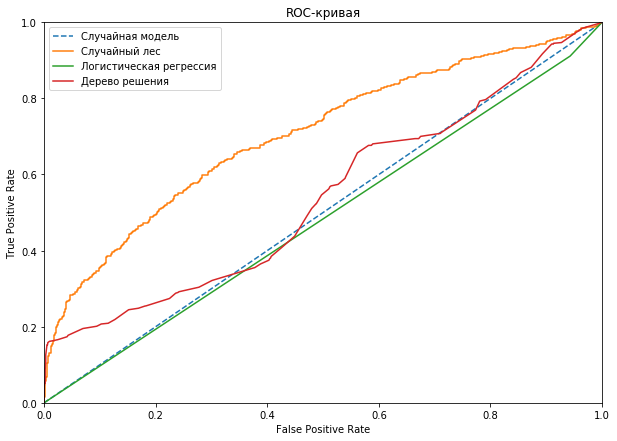

In [46]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_forest,tpr_forest)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Случайный лес','Логистическая регрессия','Дерево решения'),
           loc= 'upper left') 
plt.show()

Значение площади под кривой. На сколько наша модель отличается от случайной

Лучшее значение метрики auc roc=0.847 у модели Случайный лес

## Общий вывод:

In [83]:

rezult1={'Дерево Решения':np.array([0.586,0.582]),'Случайный лес':np.array([0.571,0.612]),'Логистическая регрессия':np.array([0.318,0.478])}
rezult_df=pd.DataFrame(rezult1,index=['R2 без учета дисбаланса','R2 с учетом дисбаланса'])

In [84]:
rezult_df

,Дерево Решения,Случайный лес,Логистическая регрессия
R2 без учета дисбаланса,0.586,0.571,0.318
R2 с учетом дисбаланса,0.582,0.612,0.478


Рассматривая данные с учетом дисбаланса + переведенные категориальные + стандартизированные данные и без учета дисбаланса тремя моделями можно сделать вывод, что самая лучшая модель оказалась Случайный лес. При лучшем значении max_depth=9,n_estimators=50, мы имеем F1 меру =0,612 на тестовой(валидной) выборке. Хуже всего себя показала модель Логистическая регрессия